In [1]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint # type: ignore #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model # type: ignore #tải mô hình
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore

#các lớp để xây dựng mô hình
from keras.models import Sequential # type: ignore #đầu vào
from keras.layers import LSTM # type: ignore #học phụ thuộc
from keras.layers import Dropout # type: ignore #tránh học tủ
from keras.layers import Dense # type: ignore #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score  # Đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error  # Đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error, f1_score  # Đo % sai số tuyệt đối trung bình

from pymongo import MongoClient

In [2]:

# Kết nối đến MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['metadata']  
collection = db['MBB']  

# Chuyển dữ liệu thành DataFrame
df = pd.DataFrame(list(collection.find({}, {"_id": 0})))
df


,Ngay,GiaDieuChinh,GiaDongCua,KhoiLuongKhopLenh,GiaTriKhopLenh,KLThoaThuan,GtThoaThuan,GiaMoCua,GiaCaoNhat,GiaThapNhat,ThayDoi_GiaTri,ThayDoi_PhanTram
0,2011-11-01,2.62,13.80,2719290,38273136000,0,0,14.50,14.50,13.80,0.00,0.00
1,2011-11-04,2.45,12.90,483860,6286356000,0,0,13.20,13.20,12.90,-0.20,-1.53
2,2011-11-14,2.26,11.90,681580,8103197000,0,0,11.90,12.00,11.80,-0.10,-0.83
3,2011-11-18,2.28,12.00,1468870,17389039000,0,0,11.80,12.00,11.60,0.10,0.84
4,2011-11-22,2.43,12.80,1100380,14043232000,0,0,12.40,13.00,12.40,0.40,3.23
...,...,...,...,...,...,...,...,...,...,...,...,...
3276,2024-12-17,24.15,24.15,3867900,93240000000,303243,7062061350,24.05,24.20,24.05,0.05,0.21
3277,2024-12-13,24.25,24.25,4396300,106672000000,302067,7392324200,24.25,24.35,24.20,-0.05,-0.21
3278,2024-12-18,24.20,24.20,3778700,91118000000,402033,9998482500,24.15,24.20,24.05,0.05,0.21
3279,2024-12-19,23.85,23.85,10456300,249996000000,72027,1797008850,23.80,24.05,23.80,-0.35,-1.45


In [3]:
# Kiểm tra dữ liệu
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3281 entries, 0 to 3280
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ngay               3281 non-null   object 
 1   GiaDieuChinh       3281 non-null   float64
 2   GiaDongCua         3281 non-null   float64
 3   KhoiLuongKhopLenh  3281 non-null   int64  
 4   GiaTriKhopLenh     3281 non-null   int64  
 5   KLThoaThuan        3281 non-null   int64  
 6   GtThoaThuan        3281 non-null   int64  
 7   GiaMoCua           3281 non-null   float64
 8   GiaCaoNhat         3281 non-null   float64
 9   GiaThapNhat        3281 non-null   float64
 10  ThayDoi_GiaTri     3281 non-null   float64
 11  ThayDoi_PhanTram   3281 non-null   float64
dtypes: float64(7), int64(4), object(1)
memory usage: 307.7+ KB


,GiaDieuChinh,GiaDongCua,KhoiLuongKhopLenh,GiaTriKhopLenh,KLThoaThuan,GtThoaThuan,GiaMoCua,GiaCaoNhat,GiaThapNhat,ThayDoi_GiaTri,ThayDoi_PhanTram
count,3281.000000,3281.000000,3.281000e+03,3.281000e+03,3.281000e+03,3.281000e+03,3281.000000,3281.000000,3281.000000,3281.000000,3281.000000
mean,9.941283,19.393219,6.244942e+06,1.483929e+11,7.534932e+05,1.615869e+10,19.398491,19.627309,19.177309,0.007309,0.057833
std,6.734373,6.095573,7.284448e+06,2.058470e+11,2.650844e+06,5.642449e+10,6.097720,6.205074,5.984916,0.437213,1.817983
min,2.200000,10.500000,5.499000e+04,7.390000e+08,0.000000e+00,0.000000e+00,10.500000,10.700000,10.400000,-12.050000,-28.790000
25%,4.030000,14.100000,9.763700e+05,1.385589e+10,0.000000e+00,0.000000e+00,14.100000,14.250000,14.000000,-0.100000,-0.750000
50%,8.290000,18.100000,3.858400e+06,7.629900e+10,3.834000e+04,6.773440e+08,18.100000,18.300000,17.950000,0.000000,0.000000
75%,15.160000,23.100000,8.637130e+06,1.901520e+11,5.157700e+05,1.116000e+10,23.100000,23.350000,22.900000,0.150000,0.800000
max,25.900000,43.450000,7.236010e+07,1.760474e+12,7.123300e+07,1.606092e+12,43.800000,44.450000,43.350000,2.650000,6.910000


In [4]:
# Xử lý thời gian và sắp xếp dữ liệu
df['Ngay'] = pd.to_datetime(df['Ngay'], format='%Y-%m-%d')
df = df.sort_values(by='Ngay')

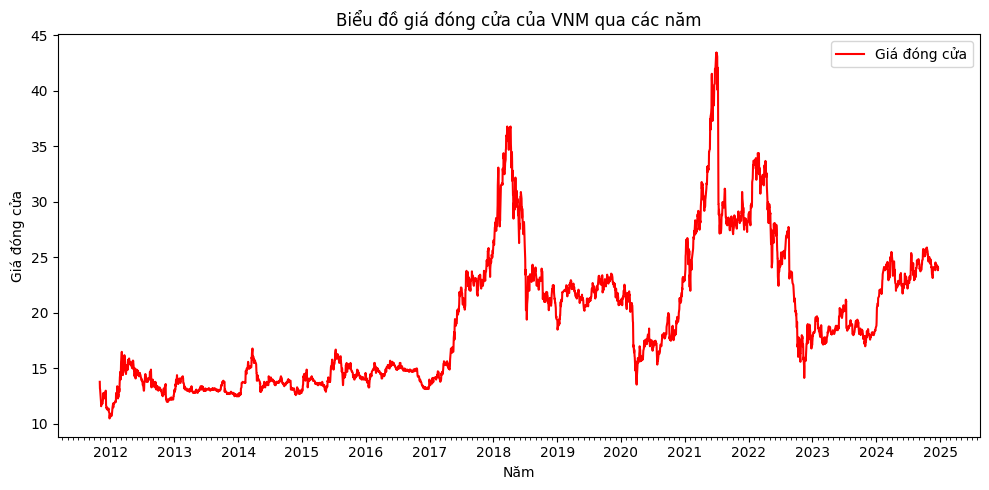

In [5]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi

# Lấy thông tin năm từ cột "Ngày"
df['Nam'] = df['Ngay'].dt.year

# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 5))
plt.plot(df['Ngay'], df['GiaDongCua'], label='Giá đóng cửa', color='red')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa của VNM qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout()
plt.show()

In [6]:
# Chuyển đổi sang chỉ số thời gian
df1 = pd.DataFrame(df, columns=['Ngay', 'GiaDongCua'])
df1.index = df1['Ngay']
df1.drop('Ngay', axis=1, inplace=True)

In [7]:
df1

,GiaDongCua
Ngay,
2011-11-01,13.80
2011-11-02,13.20
2011-11-03,13.10
2011-11-04,12.90
2011-11-07,12.30
...,...
2024-12-16,24.10
2024-12-17,24.15
2024-12-18,24.20


In [8]:
# Chia tập dữ liệu
data = df1.values
train_data = data[:int(len(df) * 0.8)]
test_data = data[int(len(df) * 0.8):]

In [9]:
data

array([[13.8 ],
       [13.2 ],
       [13.1 ],
       ...,
       [24.2 ],
       [23.85],
       [24.  ]])

In [10]:
# Chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0, 1))
sc_train = sc.fit_transform(data)

In [11]:
# Tạo cửa sổ thời gian cho tập train
x_train, y_train = [], []
for i in range(50, len(train_data)):
    x_train.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
    y_train.append(sc_train[i, 0])  # Giá trị tiếp theo
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [12]:
# Tạo cửa sổ thời gian cho tập test
x_test, y_test = [], []
for i in range(50, len(test_data)):
    x_test.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
    y_test.append(sc_train[i, 0])  # Giá trị tiếp theo
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

C:\Users\TRUONG\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100

Epoch 1: loss improved from inf to 0.21651, saving model to save_models/MBB_model.keras
41/41 - 12s - 298ms/step - loss: 0.2165 - val_loss: 0.1306
Epoch 2/100

Epoch 2: loss improved from 0.21651 to 0.13736, saving model to save_models/MBB_model.keras
41/41 - 4s - 101ms/step - loss: 0.1374 - val_loss: 0.0934
Epoch 3/100

Epoch 3: loss improved from 0.13736 to 0.10540, saving model to save_models/MBB_model.keras
41/41 - 4s - 97ms/step - loss: 0.1054 - val_loss: 0.0679
Epoch 4/100

Epoch 4: loss improved from 0.10540 to 0.08379, saving model to save_models/MBB_model.keras
41/41 - 4s - 87ms/step - loss: 0.0838 - val_loss: 0.0556
Epoch 5/100

Epoch 5: loss improved from 0.08379 to 0.07149, saving model to save_models/MBB_model.keras
41/41 - 4s - 87ms/step - loss: 0.0715 - val_loss: 0.0441
Epoch 6/100

Epoch 6: loss improved from 0.07149 to 0.06422, saving model to save_models/MBB_model.keras
41/41 - 3s - 85ms/step - loss: 0.0642 - val_loss: 0.0372
Epoch 7/100

Epoch 7: loss im

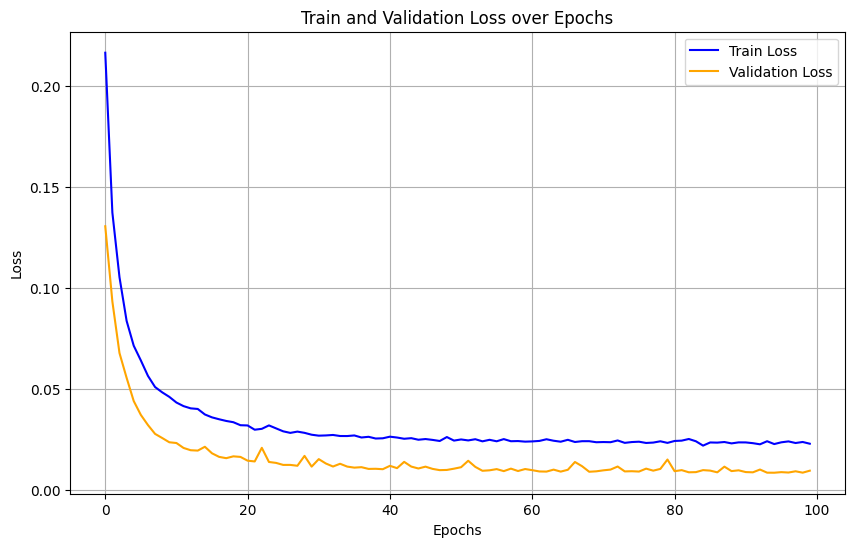

In [15]:
def build_model(input_shape):
    model = Sequential()
    
    # LSTM đầu tiên với L2 regularization
    model.add(LSTM(units=128, input_shape=input_shape, return_sequences=True, 
                   kernel_regularizer=l2(0.001)))
    
    # LSTM thứ hai với L2 regularization
    model.add(LSTM(units=64, kernel_regularizer=l2(0.001)))
    
    # Tăng Dropout để giảm overfitting
    model.add(Dropout(0.5))
    
    # Lớp Dense để đưa ra kết quả dự đoán
    model.add(Dense(1))
    
    # Compile mô hình với learning rate thấp để ổn định huấn luyện
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.0005))
    
    return model

# Xây dựng mô hình
input_shape = (x_train.shape[1], x_train.shape[2])  # Điều chỉnh để phù hợp với đầu vào
model = build_model(input_shape)

# Đường dẫn lưu mô hình
save_model_path = "save_models/MBB_model.keras"

# Callbacks: ModelCheckpoint và EarlyStopping
callbacks = [
    ModelCheckpoint(save_model_path, monitor='loss', verbose=2, save_best_only=True, mode='auto'),
    EarlyStopping(monitor='loss', patience=30, restore_best_weights=True, verbose=2)
]

# Huấn luyện mô hình và lưu kết quả vào history
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),  # Thêm tập validation
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=callbacks
)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')  # Thêm val_loss
plt.title('Train and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Hàm xây dựng mô hình
def build_model():
    model = Sequential()
    model.add(LSTM(units=128, input_shape=(x_train.shape[1], 1), return_sequences=True))
    model.add(LSTM(units=64))
    model.add(Dropout(0.4))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

In [19]:
# Huấn luyện mô hình
model = build_model()
save_model_path = f"save_models/{collection}_model.keras"
best_model = ModelCheckpoint(save_model_path, monitor='loss', verbose=2, save_best_only=True, mode='auto')
model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=2, callbacks=[best_model])

Epoch 1/100


C:\Users\TRUONG\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: loss improved from inf to 0.01953, saving model to save_models/Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metadata'), 'ACB')_model.keras
72/72 - 9s - 127ms/step - loss: 0.0195
Epoch 2/100

Epoch 2: loss improved from 0.01953 to 0.01390, saving model to save_models/Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metadata'), 'ACB')_model.keras
72/72 - 5s - 67ms/step - loss: 0.0139
Epoch 3/100

Epoch 3: loss improved from 0.01390 to 0.01147, saving model to save_models/Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metadata'), 'ACB')_model.keras
72/72 - 5s - 69ms/step - loss: 0.0115
Epoch 4/100

Epoch 4: loss did not improve from 0.01147
72/72 - 5s - 64ms/step - loss: 0.0124
Epoch 5/100

Epoch 5: loss improved from 0.01147 to 0.01087, saving model to save_models/Collection(Database(Mongo

In [13]:
save_model_path = "save_models/MBB_model.keras"
# Tải mô hình tốt nhất
final_model = load_model(save_model_path)

In [14]:
# Dự đoán trên tập train
y_train_predict = final_model.predict(x_train)
y_train_predict = sc.inverse_transform(y_train_predict)
y_train = sc.inverse_transform(y_train.reshape(-1, 1))

81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step


In [15]:
#xử lý dữ liệu test
test = df1[len(train_data)-50:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(50,test.shape[0]):
  x_test.append(sc_test[i-50:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[int(len(df) * 0.8):] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


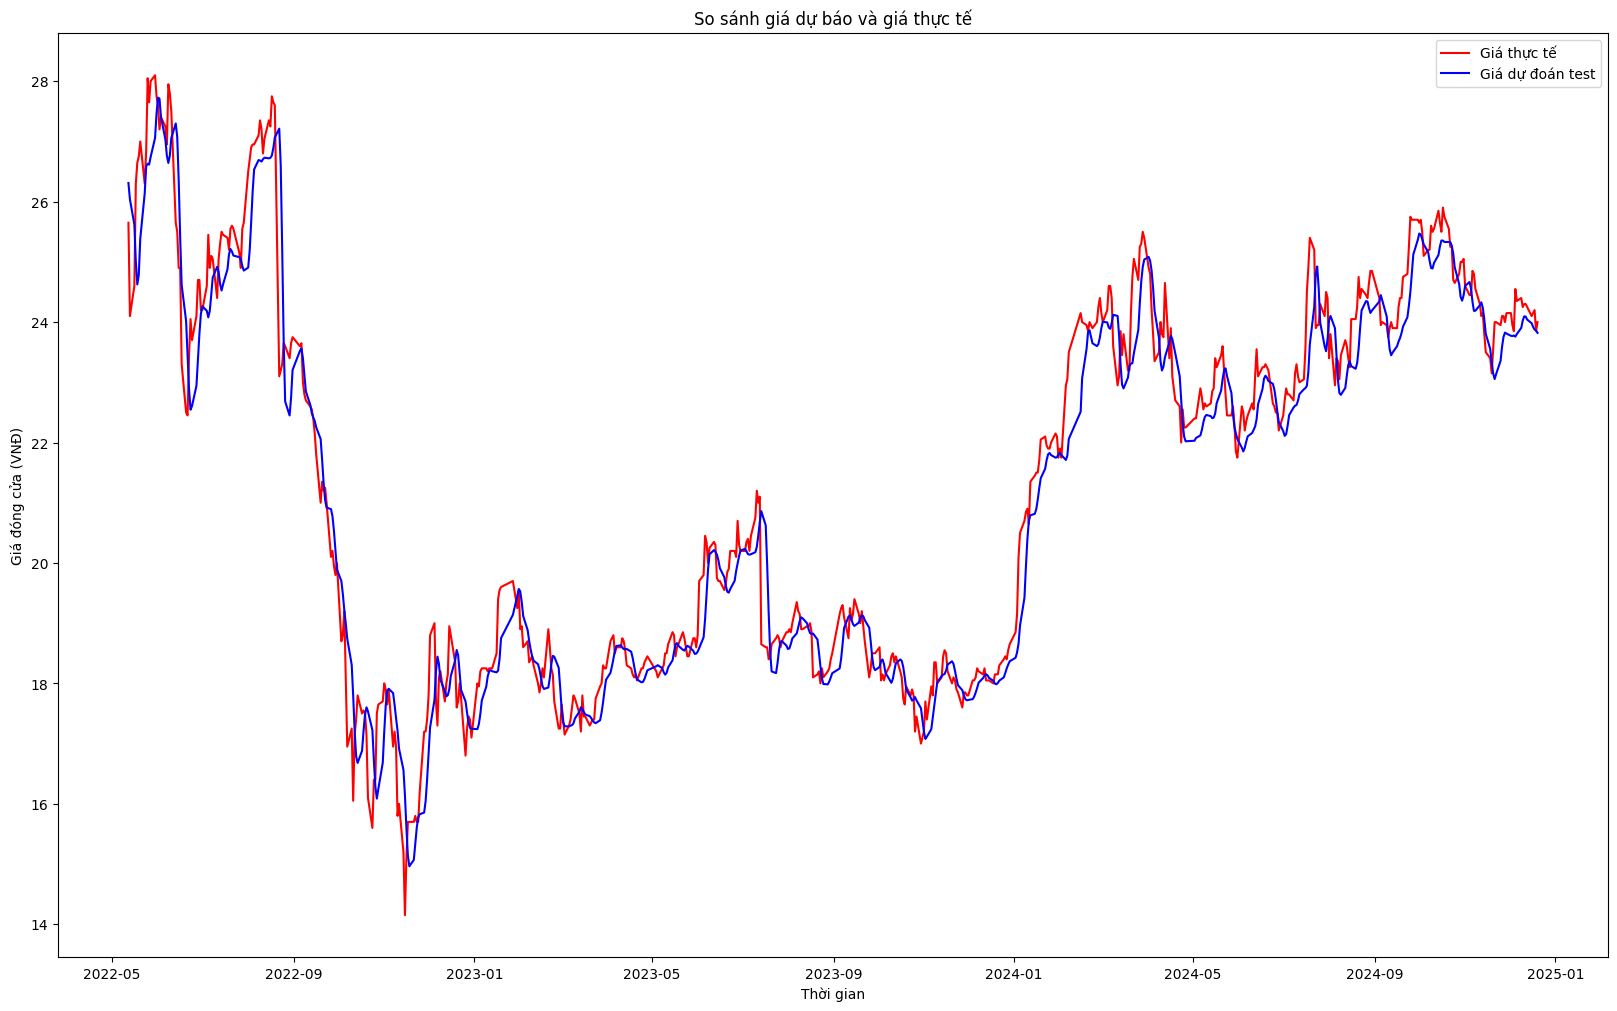

In [16]:
# Chọn dữ liệu cho test_data1
num_test_predictions = len(y_test_predict)
test_data1 = df.iloc[-num_test_predictions:].copy()
plt.figure(figsize=(20, 12))
if 'Ngay' in test_data1.columns:
    plt.plot(test_data1['Ngay'], test_data1['GiaDongCua'], label='Giá thực tế', color='red')
else:
    raise KeyError("Cột 'Ngày' không tồn tại trong test_data1.")

test_data1 = test_data1.copy()
test_data1['Dự đoán'] = y_test_predict.flatten()
plt.plot(test_data1['Ngay'], test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.title('So sánh giá dự báo và giá thực tế')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.legend()
plt.show()


In [20]:
print('--- Kết quả trên tập train ---')
# R2 score
print('Độ phù hợp tập train (R2):', r2_score(y_train, y_train_predict))

# MAE
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):', mean_absolute_error(y_train, y_train_predict))

# MAPE
print('Phần trăm sai số tuyệt đối trung bình trên tập train:', mean_absolute_percentage_error(y_train, y_train_predict) * 100)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predict))
print('RMSE trên tập train (VNĐ):', rmse_train)

# Accuracy (dựa trên RMSE và biên độ giá trị thực tế)
range_y_train = np.max(y_train) - np.min(y_train)
accuracy_train = 1 - (rmse_train / range_y_train)
print('Độ chính xác trên tập train (%):', accuracy_train * 100)

# F1 Score (Chuyển thành bài toán phân loại)
error_threshold = 10  # Ngưỡng sai số
y_train_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_train, y_train_predict)]
y_train_pred_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_train, y_train_predict)]
f1_train = f1_score(y_train_class, y_train_pred_class)
print('F1 Score trên tập train:', f1_train)
print("----------------------------------------------------")

--- Kết quả trên tập train ---
Độ phù hợp tập train (R2): 0.9875832566005768
Sai số tuyệt đối trung bình trên tập train (VNĐ): 0.45073304439387585
Phần trăm sai số tuyệt đối trung bình trên tập train: 2.1622016886265922
RMSE trên tập train (VNĐ): 0.7275445864834442
Độ chính xác trên tập train (%): 97.75102137099398
F1 Score trên tập train: 1.0
----------------------------------------------------


In [21]:
y_test = data[-len(y_test_predict):]

In [22]:
print('--- Kết quả trên tập test ---')
# R2 score
print('Độ phù hợp tập test (R2):', r2_score(y_test, y_test_predict))

# MAE
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):', mean_absolute_error(y_test, y_test_predict))

# MAPE
print('Phần trăm sai số tuyệt đối trung bình trên tập test:', mean_absolute_percentage_error(y_test, y_test_predict) * 100)

# RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
print('RMSE trên tập test (VNĐ):', rmse_test)

# Accuracy (dựa trên RMSE và biên độ giá trị thực tế)
range_y_test = np.max(y_test) - np.min(y_test)
accuracy_test = 1 - (rmse_test / range_y_test)
print('Độ chính xác trên tập test (%):', accuracy_test * 100)

# F1 Score (Chuyển thành bài toán phân loại)
y_test_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_test, y_test_predict)]
y_test_pred_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_test, y_test_predict)]
f1_test = f1_score(y_test_class, y_test_pred_class)
print('F1 Score trên tập test:', f1_test)
print("----------------------------------------------------")

--- Kết quả trên tập test ---
Độ phù hợp tập test (R2): 0.9565982508707664
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.481771273155735
Phần trăm sai số tuyệt đối trung bình trên tập test: 2.262376995857637
RMSE trên tập test (VNĐ): 0.6628593492984544
Độ chính xác trên tập test (%): 95.24832007671358
F1 Score trên tập test: 1.0
----------------------------------------------------
